## Distributions
- We'll use the `empiricaldist` package
- Probability mass function = mapping of each discrete outcome to its probability
- The `empiricaldist.Pmf` class inherits from a Pandas Series, so anything you can do with a Series, you can also do with a `Pmf`.

$$P(H|D) = \frac{P(H)P(D|H)}{P(D)}$$

In [25]:
from empiricaldist import Pmf
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
coin = Pmf()
coin["heads"] = 1/2
coin["tails"] = 1/2
coin

,probs
heads,0.5
tails,0.5


In [3]:
die = Pmf.from_seq(range(1, 7))
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [4]:
letters = Pmf.from_seq(list("Mississippi"))
letters

,probs
M,0.090909
i,0.363636
p,0.181818
s,0.363636


In [5]:
# api surface mimics pandas Series
letters["s"]

0.36363636363636365

In [6]:
# api surface allows treating Pmf as a function
letters('s')

0.36363636363636365

In [7]:
# With parentheses, you can also provide a sequence of quantities and get a sequence of probabilities.
die([1, 4, 7])

array([0.16666667, 0.16666667, 0.        ])

## The Cookie Problem Revisited

Suppose there are two bowls of cookies.

Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies.

Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.

Now suppose you choose one of the bowls at random and, without looking, choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

In [8]:
# This distribution, which contains the prior probability for each hypothesis, is called (wait for it) 
# This is the "prior distribution"

prior = Pmf.from_seq(["Bowl 1", "Bowl 2"])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


In [9]:
# P(Vanilla|Bowl1) = 0.75, P(Vanilla|Bowl2) = 0.5
likelihood_vanilla = [0.75, 0.5]

# unnormalized posteriors
posterior = prior * likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


In [10]:
# P(data) is the probability of the data
# P(Vanilla from anywhere) = 5/8
posterior.normalize()

0.625

In [11]:
# Posterior distribution
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


In [12]:
posterior("Bowl 1")

0.6

> One benefit of using Pmf objects is that it is easy to do successive updates with more data. For example, suppose you put the first cookie back (so the contents of the bowls don’t change) and draw again from the same bowl. If the second cookie is also vanilla, we can do a second update like this:

In [13]:
# Assuming we replace the original cookie
# Posterior odds of selecting another vanilla cookie?
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


In [14]:
# Let's switch to investigating chocolate
likelihood_chocolate = [0.25, 0.5]

# Here's the update
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


## Takeaways so far:

- Now the posterior probability for Bowl 1 is about 53%. After two vanilla cookies and one chocolate, the posterior probabilities are close to 50/50.
- TODO: Model this simulation without `empiricaldist`

# 101 Bowls

Next let’s solve a cookie problem with 101 bowls:

- Bowl 0 contains 0% vanilla cookies,
- Bowl 1 contains 1% vanilla cookies,
- Bowl 2 contains 2% vanilla cookies,

and so on, up to

- Bowl 99 contains 99% vanilla cookies, and
- Bowl 100 contains all vanilla cookies.

> Suppose we choose a bowl at random, choose a cookie at random, and it turns out to be vanilla. What is the probability that the cookie came from Bowl 𝑥, for each value of 𝑥?

In [23]:
# Setup 101 numbered bowls
hypos = np.arange(101)

In [16]:
prior = Pmf(1, hypos)
prior.normalize()

101

In [19]:
# Even likelihood of selecting any of the bowls at random
prior.head()

,probs
0,0.009901
1,0.009901
2,0.009901


In [24]:
# Create likelihoods of vanilla for each bowl
likelihood_vanilla = hypos/100
likelihood_vanilla[:4]

array([0.  , 0.01, 0.02, 0.03])

$$Prior = P(H)$$
$$Likelihood = P(D|H)$$

Bayesian numerator = Prior * Likelihood = $P(H)*P(D|H)$

Bayesian denominator = $P(D)$

In [27]:
# multiply likelihoods by priors
posterior1 = prior * likelihood_vanilla
posterior1.normalize()
posterior1.head()

,probs
0,0.000000
1,0.000198
2,0.000396


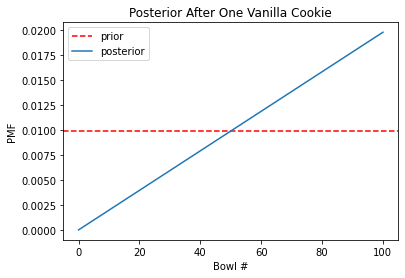

In [70]:
# This figure shows the prior distribution and the posterior distribution 
# after one vanilla cookie.

plt.title("Posterior After One Vanilla Cookie")
plt.xlabel("Bowl #")
plt.ylabel("PMF")
plt.axhline(y=0.009901, color="red", linestyle="--", label="prior");
plt.plot(hypos, posterior1, label="posterior");
plt.legend();

The posterior probability of Bowl 0 is 0 because it contains no vanilla cookies. The posterior probability of Bowl 100 is the highest because it contains the most vanilla cookies. In between, the shape of the posterior distribution is a line because the likelihoods are proportional to the bowl numbers.

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie. Here’s the update after the second cookie:

In [52]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()
posterior2.head()

,probs
0,0.000000
1,0.000003
2,0.000012


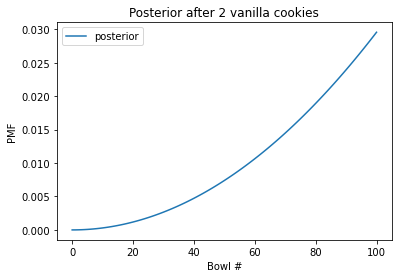

In [56]:
plt.title("Posterior after 2 vanilla cookies")
plt.ylabel("PMF")
plt.xlabel("Bowl #")
plt.plot(posterior2, label="posterior");
plt.legend();

After two vanilla cookies, the high-numbered bowls have the highest posterior probabilities because they contain the most vanilla cookies; the low-numbered bowls have the lowest probabilities.

But suppose we draw again and get a chocolate cookie. Here’s the update:

In [60]:
likelihood_chocolate = 1 - hypos/100
posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()
posterior3.head()

,probs
0,0.000000
1,0.000012
2,0.000047


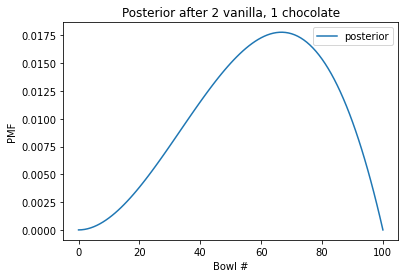

In [64]:
# And here’s the posterior distribution.
plt.title("Posterior after 2 vanilla, 1 chocolate")
plt.ylabel("PMF")
plt.xlabel("Bowl #")
plt.plot(hypos, posterior3, label="posterior");
plt.legend();

In [65]:
# Bowl #67 has the highest posterior probability
# MAP = Maxiumum a- posteori probability, which is Latin for "posterior"
posterior3.idxmax()

67

## Let's model after 2 vanilla and 2 chocolate!

In [66]:
posterior4 = posterior3 * likelihood_chocolate
posterior4.normalize()
posterior4.head()

,probs
0,0.000000
1,0.000029
2,0.000115


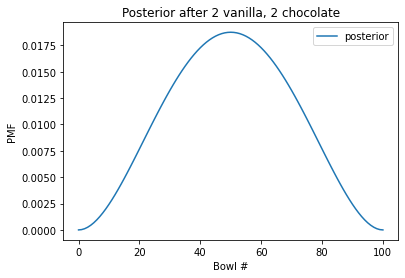

In [67]:
# And here’s the posterior distribution.
plt.title("Posterior after 2 vanilla, 2 chocolate")
plt.ylabel("PMF")
plt.xlabel("Bowl #")
plt.plot(hypos, posterior4, label="posterior");
plt.legend();

In [68]:
# Let's setup for 11 more chocolate cookies
for i in range(11):
    posterior4 = posterior4 * likelihood_chocolate
    posterior4.normalize()

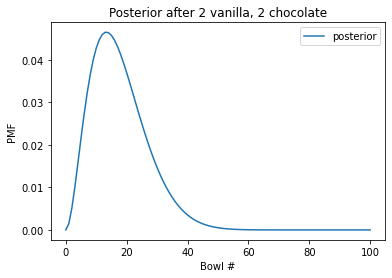

In [69]:
# And here’s the posterior distribution.
plt.title("Posterior after 2 vanilla, 13 chocolate")
plt.ylabel("PMF")
plt.xlabel("Bowl #")
plt.plot(hypos, posterior4, label="posterior");
plt.legend();

In [71]:
posterior4.idxmax()

13

# Thoughts so far...
- I need to "animate" this interaction
- Maybe add a slider or interactive component
    - Slider for vanilla outcomes out
    - Another slider for chocolate outcomes out
- Maybe plotly/dash is helpful here?

<hr>

## Let's revisit The Dice Problem
- We have a box with a d6, d8, and a d12
- If I choose a die at random and roll a 1 (prior)
- What's the probability that I choose the d6?

In [ ]:
hypot